# sample of stuff within 1 kpc

Benjamin Pennell

--

Max Planck Institut für Astronomie, Heidelberg

---

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from astropy.io import ascii
from scipy.optimize import minimize
from scipy.stats import kstest, ks_2samp
import pickle
from scipy.interpolate import RegularGridInterpolator
import h5py
import matplotlib
import pandas as pd

from astropy.table import Table
from astroquery.gaia import Gaia

/home/bepennell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Workaround solutions for the Gaia Archive issues following the infrastructure upgrade: https://www.cosmos.esa.int/web/gaia/news#WorkaroundArchive


In [11]:
msms = h5py.File("../../BigData/msms_36m_v0.hdf5", "r")

## Create the catalogue

### load the msms catalogue, relevant columns

In [52]:
new_table = Table()

In [53]:
labels = ["source_id", "parallax", "ra", "dec", "phot_g_mean_mag", "mass_single", "predicted_class", "bp_rp", "mh_single"]
for label in labels:
    new_table.add_column(np.array(msms["table"]["columns"][label]["data"]), name=label)

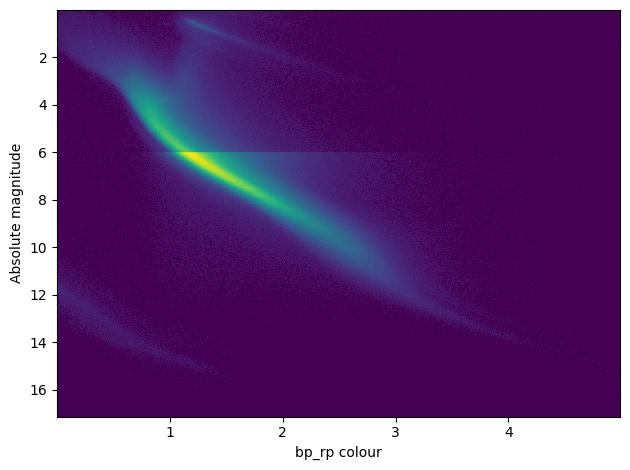

In [7]:
bp_rp = new_table["bp_rp"]
parallax = new_table["parallax"]
gmag = new_table["phot_g_mean_mag"]
absolute_magnitudes = gmag + 5 * np.log10(parallax) - 10

plt.hist2d(bp_rp, absolute_magnitudes, bins=1000, norm=matplotlib.colors.PowerNorm(0.4));
plt.ylabel("Absolute magnitude");
plt.xlabel("bp_rp colour");
plt.ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes));
plt.xlim([np.min(bp_rp), np.max(bp_rp)]);
plt.tight_layout()

In [54]:
SINGLE_MASK = new_table["predicted_class"] == 0
PARALLAX_MASK = (new_table["parallax"] < 10) & (new_table["parallax"] > 5) # 50-250pc
MASS_MASK = (new_table["mass_single"] < 0.4) & (new_table["mass_single"] > 0.1)
ARBITRARY_CUT = new_table["bp_rp"] > 2
total_mask = SINGLE_MASK & PARALLAX_MASK & MASS_MASK & ARBITRARY_CUT

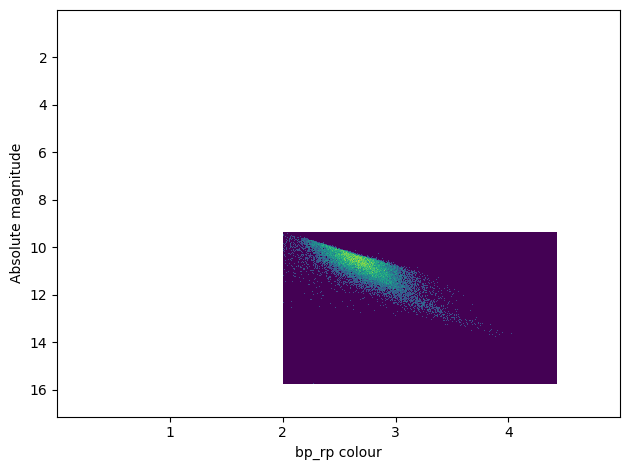

In [8]:
bp_rp_red = bp_rp[total_mask]
mags_red = absolute_magnitudes[total_mask]

plt.hist2d(bp_rp_red, mags_red, bins=1000, norm=matplotlib.colors.PowerNorm(0.4));
plt.ylabel("Absolute magnitude");
plt.xlabel("bp_rp colour");
plt.ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes));
plt.xlim([np.min(bp_rp), np.max(bp_rp)]);
plt.tight_layout()

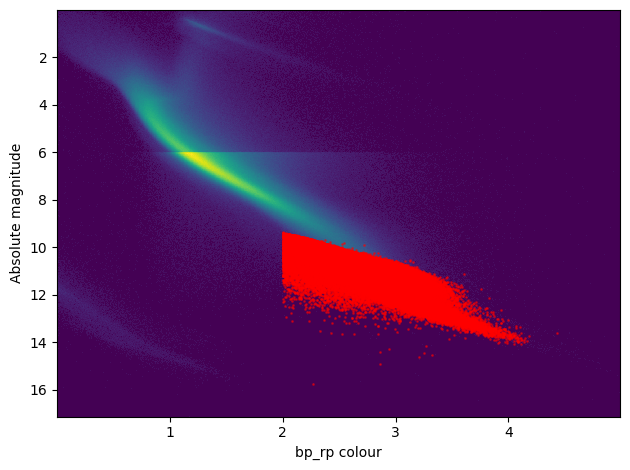

In [9]:
plt.hist2d(bp_rp, absolute_magnitudes, bins=1000, norm=matplotlib.colors.PowerNorm(0.4));
plt.scatter(bp_rp_red, mags_red, c="r", s=1, alpha=0.5)
plt.ylabel("Absolute magnitude");
plt.xlabel("bp_rp colour");
plt.ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes));
plt.xlim([np.min(bp_rp), np.max(bp_rp)]);
plt.tight_layout()

In [6]:
masked_table = new_table[total_mask]

In [7]:
len(new_table), len(masked_table), "{:.2f}%".format(len(masked_table)/len(new_table)*100)

(35831031, 275438, '0.77%')

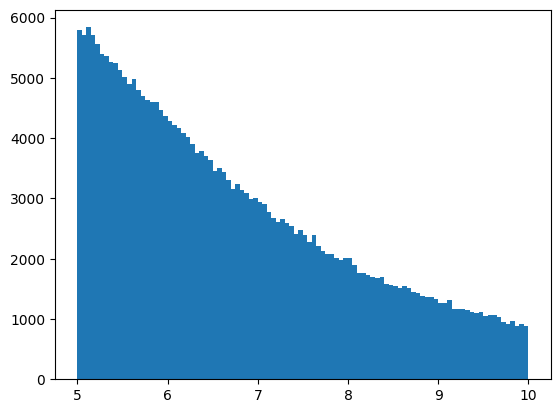

In [8]:
plt.hist(masked_table["parallax"], bins=100);

### append things from gaia

In [11]:
job = Gaia.launch_job_async("""SELECT *
                                FROM gaiadr3.nss_two_body_orbit AS g
                                WHERE g.parallax > 5
                                AND g.parallax < 10
                                """)

nss_table = job.get_results()

job = Gaia.launch_job_async("""SELECT *
                                FROM gaiadr3.nss_acceleration_astro AS g
                                WHERE g.parallax > 5
                                AND g.parallax < 10
                                """)

accel_table = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [77]:
# a test
job = Gaia.launch_job_async(r"""select pmra, pmdec, ruwe
                        from gaiadr3.gaia_source 
                        where source_id = 5478926884285078784""")
results = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [21]:
import os
os.environ["XDG_CACHE_HOME"] = os.path.expanduser("~/.astroquery_tmp")

In [12]:
def chunk_list(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

batch_size = 1000  # Gaia can usually handle 50-100 IDs per query

all_results = []

for batch in tqdm(list(chunk_list(masked_table["source_id"], batch_size))):
    ids_str = ",".join(str(sid) for sid in batch)
    query = f"""
    SELECT source_id, pmra, pmdec, ruwe
    FROM gaiadr3.gaia_source
    WHERE source_id IN ({ids_str})
    """
    job = Gaia.launch_job_async(query, verbose=False)
    results = job.get_results()
    all_results.append(results.to_pandas())

df = pd.concat(all_results, ignore_index=True)

  0%|          | 0/276 [00:00<?, ?it/s]

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [13]:
masked_table.add_column(np.zeros(len(masked_table)), name="pmra")
masked_table.add_column(np.zeros(len(masked_table)), name="pmdec")
masked_table.add_column(np.zeros(len(masked_table)), name="ruwe")
masked_table.add_column(np.zeros(len(masked_table)), name="solution_type")

In [14]:
mask = np.in1d(masked_table["source_id"], df["source_id"])  # boolean mask for rows to update
data_indices = np.where(mask)[0]

# Step 2: Map update indices
update_map = {sid: i for i, sid in enumerate(df['source_id'])}

# Step 3: Update only the desired columns
for col in ['pmra', 'pmdec', 'ruwe']:
    # Pick corresponding values from updates_df
    masked_table[col][data_indices] = [df[col][update_map[sid]] for sid in masked_table['source_id'][data_indices]]

/tmp/ipykernel_3723841/2458955827.py:1: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  mask = np.in1d(masked_table["source_id"], df["source_id"])  # boolean mask for rows to update


In [17]:
accel_ids = list(accel_table["source_id"])
nss_ids = list(nss_table["source_id"])

for row in tqdm(masked_table):
    if row["ruwe"] < 1.4:
        row["solution_type"] = int(0)
    elif row["source_id"] in nss_ids:
        row["solution_type"] = int(12)
    elif row["source_id"] in accel_ids:
        if accel_table[accel_table["source_id"] == row["source_id"]]["nss_solution_type"][0] == "Acceleration7":
            row["solution_type"] = int(7)
        elif accel_table[accel_table["source_id"] == row["source_id"]]["nss_solution_type"][0] == "Acceleration9":
            row["solution_type"] = int(9)
    else:
        row["solution_type"] = int(5)

  0%|          | 0/275438 [00:00<?, ?it/s]

In [ ]:
masked_table.remove_column("col0")

In [18]:
lowrs = len(masked_table[masked_table["solution_type"] == 0])/len(masked_table)*100
highrs = len(masked_table[masked_table["solution_type"] == 5])/len(masked_table)*100
accels = len(masked_table[masked_table["solution_type"] == 7])/len(masked_table)*100
jerks = len(masked_table[masked_table["solution_type"] == 9])/len(masked_table)*100
nsss = len(masked_table[masked_table["solution_type"] == 12])/len(masked_table)*100
highruwes = len(masked_table[masked_table["ruwe"] > 1.4])/len(masked_table)*100
print(lowrs, highrs, accels, jerks, nsss)
print(int(accels/100*len(masked_table)), int(jerks/100*len(masked_table)), int(nsss/100*len(masked_table)))

95.00504650774403 4.769494405274508 0.12779645510060342 0.03267522999731337 0.06498740188354549
352 90 179


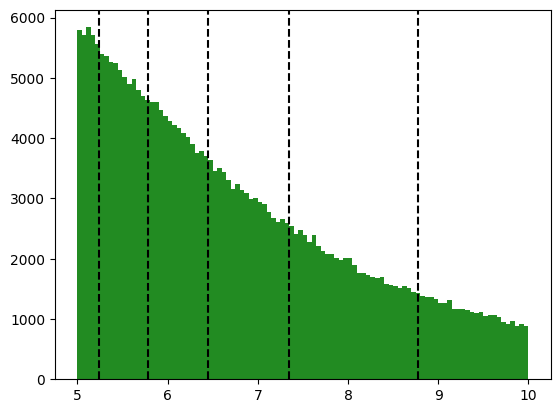

In [ ]:
plt.hist(masked_table["parallax"], bins=100, color="forestgreen");
plt.axvline(np.percentile(masked_table["parallax"], 10), c="k", linestyle="--");
plt.axvline(np.percentile(masked_table["parallax"], 30), c="k", linestyle="--");
plt.axvline(np.percentile(masked_table["parallax"], 50), c="k", linestyle="--");
plt.axvline(np.percentile(masked_table["parallax"], 70), c="k", linestyle="--");
plt.axvline(np.percentile(masked_table["parallax"], 90), c="k", linestyle="--");

In [20]:
masked_table.write('./data/200pc_mdwarfs.fits', format='fits', overwrite=True)

## Visualising the data and cleaning

In [2]:
t_loaded = Table.read('../data/200pc_mdwarfs.fits', format='fits')

In [3]:
rates = [len(t_loaded[t_loaded["solution_type"] == soltype])/len(t_loaded)*100 for soltype in [0,5,7,9,12]]
grid = [
    rates,
    [int(grp/100*len(t_loaded)) for grp in rates]
]
row_labels = ["Rate (%)", "Counts"]
col_labels = ["low RUWE", "high RUWE", "Acceleration", "Jerk", "Full Orbit"]
pd.DataFrame(grid, index=row_labels, columns=col_labels)

,low RUWE,high RUWE,Acceleration,Jerk,Full Orbit
Rate (%),95.005047,4.769494,0.127796,0.032675,0.064987
Counts,261680.000000,13137.000000,352.000000,90.000000,179.000000


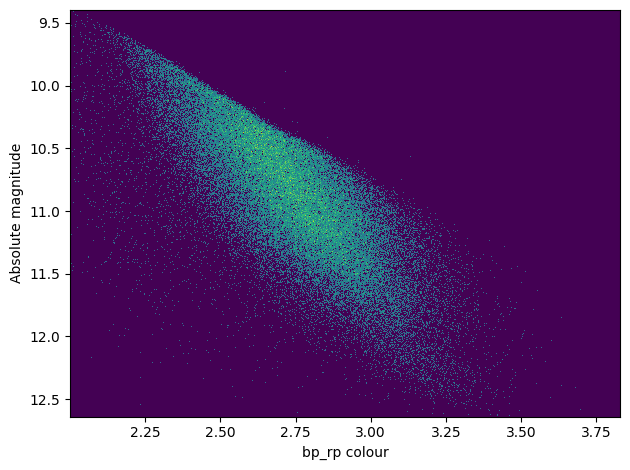

In [4]:
bp_rp = t_loaded["bp_rp"]
parallax = t_loaded["parallax"]
gmag = t_loaded["phot_g_mean_mag"]
absolute_magnitudes = gmag + 5 * np.log10(parallax) - 10

plt.hist2d(bp_rp, absolute_magnitudes, bins=1000, norm=matplotlib.colors.PowerNorm(0.4));
plt.ylabel("Absolute magnitude");
plt.xlabel("bp_rp colour");
plt.ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes));
plt.xlim([np.min(bp_rp), np.max(bp_rp)]);
plt.tight_layout()

In [5]:
soltypes = [0,5,7,9,12]
solution_colormap = plt.get_cmap('Accent')(np.linspace(0, 1, 8))[:5]
CMAP = matplotlib.colors.ListedColormap(solution_colormap)

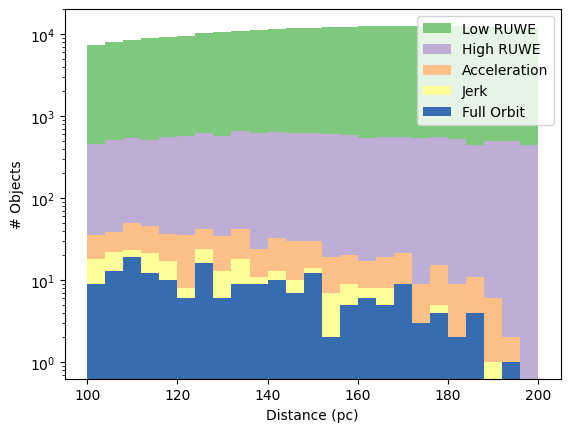

In [6]:
tbins = plt.hist(1000/t_loaded["parallax"], color=solution_colormap[0], bins=25, label="Low RUWE");
plt.hist(1000/t_loaded[np.isin(t_loaded["solution_type"], [5, 7, 9, 12])]["parallax"], bins=tbins[1], color=solution_colormap[1], label="High RUWE");
plt.hist(1000/t_loaded[np.isin(t_loaded["solution_type"], [7, 9, 12])]["parallax"], bins=tbins[1], color=solution_colormap[2], label="Acceleration");
plt.hist(1000/t_loaded[np.isin(t_loaded["solution_type"], [9, 12])]["parallax"], bins=tbins[1], color=solution_colormap[3], label="Jerk");
plt.hist(1000/t_loaded[t_loaded["solution_type"] == 12]["parallax"], bins=tbins[1], color=solution_colormap[4], label="Full Orbit");
plt.yscale("log");
plt.xlabel("Distance (pc)");
plt.ylabel("# Objects");
plt.legend();

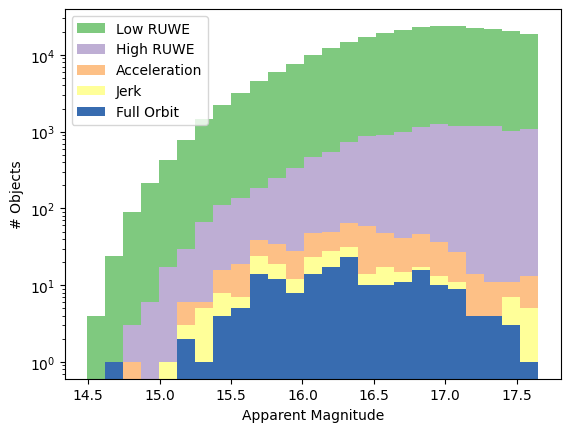

In [7]:
tbins = plt.hist(t_loaded["phot_g_mean_mag"], color=solution_colormap[0], bins=25, label="Low RUWE");
plt.hist(t_loaded[np.isin(t_loaded["solution_type"], [5, 7, 9, 12])]["phot_g_mean_mag"], bins=tbins[1], color=solution_colormap[1], label="High RUWE");
plt.hist(t_loaded[np.isin(t_loaded["solution_type"], [7, 9, 12])]["phot_g_mean_mag"], bins=tbins[1], color=solution_colormap[2], label="Acceleration");
plt.hist(t_loaded[np.isin(t_loaded["solution_type"], [9, 12])]["phot_g_mean_mag"], bins=tbins[1], color=solution_colormap[3], label="Jerk");
plt.hist(t_loaded[t_loaded["solution_type"] == 12]["phot_g_mean_mag"], bins=tbins[1], color=solution_colormap[4], label="Full Orbit");
plt.yscale("log");
plt.xlabel("Apparent Magnitude");
plt.ylabel("# Objects");
plt.legend();

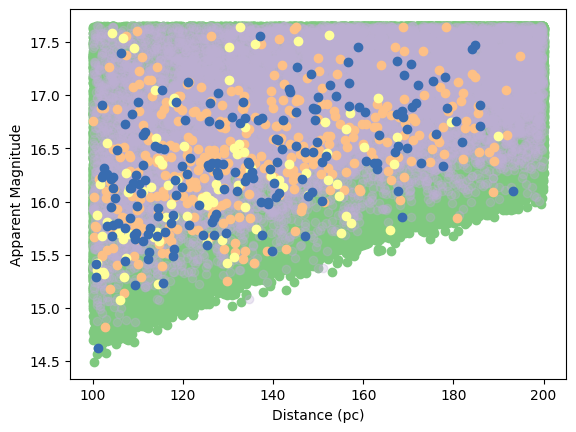

In [8]:
for i in range(5):
    soltype_mask = t_loaded["solution_type"] == soltypes[i]
    alpha = 1
    if i == 1:
        alpha = 0.3
    plt.scatter(1000/t_loaded[soltype_mask]["parallax"], t_loaded[soltype_mask]["phot_g_mean_mag"], color=solution_colormap[i], alpha=alpha);

plt.xlabel("Distance (pc)");
plt.ylabel("Apparent Magnitude");

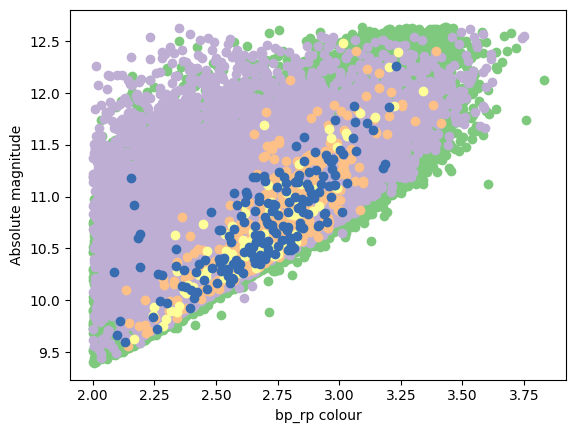

In [9]:
for i in range(5):
    soltype_mask = t_loaded["solution_type"] == soltypes[i]
    
    bp_rp = t_loaded[soltype_mask]["bp_rp"]
    parallax = t_loaded[soltype_mask]["parallax"]
    gmag = t_loaded[soltype_mask]["phot_g_mean_mag"]
    absolute_magnitudes = gmag + 5 * np.log10(parallax) - 10
    plt.scatter(bp_rp, absolute_magnitudes, color=solution_colormap[i]);

plt.ylabel("Absolute magnitude");
plt.xlabel("bp_rp colour");

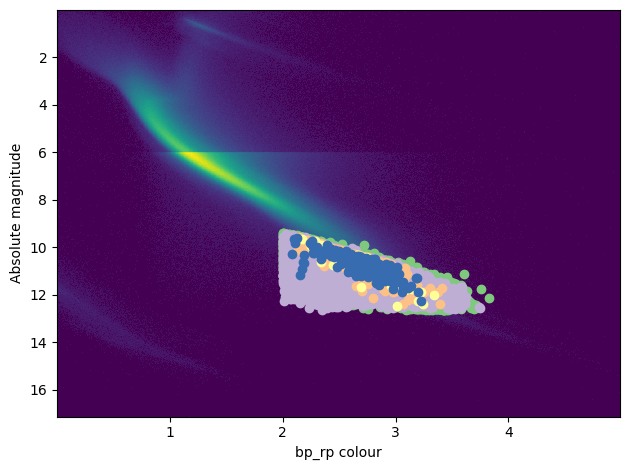

In [12]:
new_table = Table()
labels = ["source_id", "parallax", "ra", "dec", "phot_g_mean_mag", "mass_single", "predicted_class", "bp_rp", "mh_single"]
for label in labels:
    new_table.add_column(np.array(msms["table"]["columns"][label]["data"]), name=label)
bp_rp = new_table["bp_rp"]
parallax = new_table["parallax"]
gmag = new_table["phot_g_mean_mag"]
absolute_magnitudes = gmag + 5 * np.log10(parallax) - 10

plt.hist2d(bp_rp, absolute_magnitudes, bins=1000, norm=matplotlib.colors.PowerNorm(0.4));
plt.ylabel("Absolute magnitude");
plt.xlabel("bp_rp colour");
plt.ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes));
plt.xlim([np.min(bp_rp), np.max(bp_rp)]);

for i in range(5):
    soltype_mask = t_loaded["solution_type"] == soltypes[i]
    
    bp_rp = t_loaded[soltype_mask]["bp_rp"]
    parallax = t_loaded[soltype_mask]["parallax"]
    gmag = t_loaded[soltype_mask]["phot_g_mean_mag"]
    absolute_magnitudes = gmag + 5 * np.log10(parallax) - 10
    plt.scatter(bp_rp, absolute_magnitudes, color=solution_colormap[i]);
    
plt.tight_layout()

looks a bit weird. Here are two options of things we could do to improve the data:
- use isochrones to cut off the objects away from the main sequence. After all, those objects appear to have no high order solutions, so it's not really fair to run them through the machinery. There are not a large number of these objects, so it's not a big deal 
- use the chi2 for single, binary stars to perhaps evaluate spurious solutions

### exploring the chi2

In [55]:
msms["table"]["columns"].keys()

<KeysViewHDF5 ['E_binary', 'E_single', 'MG_prim', 'MG_second', 'b_r_prim', 'b_r_second', 'bp_rp', 'chi2_diff_mh_mass', 'chi2_mass_mh', 'chi2_mass_mh_binary', 'dec', 'e_E_binary', 'e_E_single', 'e_m1_binary', 'e_mass_single', 'e_mh_binary', 'e_mh_single', 'e_q_binary', 'fit_status_binary', 'fit_status_single', 'fit_success_binary', 'fit_success_single', 'flag_extrap_m2', 'flux_ratio_mean', 'flux_ratio_std', 'm1_binary', 'm2_binary', 'mass_single', 'mh_binary', 'mh_single', 'parallax', 'parallax_error', 'phot_g_mean_mag', 'predicted_class', 'q_binary', 'ra', 'radial_velocity', 'radial_velocity_error', 'source_id']>

In [91]:
labels = ['chi2_diff_mh_mass', 'chi2_mass_mh', 'chi2_mass_mh_binary', 'fit_status_single', 'fit_success_binary', 'parallax_error']
chi2_table = Table()
for label in labels:
    chi2_table.add_column(np.array(msms["table"]["columns"][label]["data"]), name=label)
chi2_table = chi2_table[total_mask]

In [88]:
len(chi2_table[chi2_table["fit_success_binary"]]), len(chi2_table)

(275433, 275438)

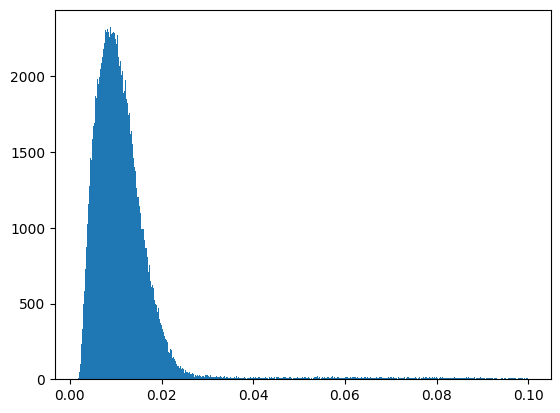

In [96]:
plt.hist(chi2_table["parallax_error"]/t_loaded["parallax"], bins=1000);

In [136]:
def gaussian(x, mu, sigma):
    '''
        this function evaluates a normalised gaussian at x, defined by two
        parameters: peak (mu) and width (sigma)
    '''
    return np.exp(-(mu - x)**2/(2*sigma**2)) / np.sqrt(2 * np.pi * sigma**2)

def area_in_range(target_range, mu, sigma, resolution=100):
    xs = np.linspace(*target_range, resolution)
    ys = gaussian(xs, mu, sigma)
    return np.trapezoid(y=ys, x=xs)

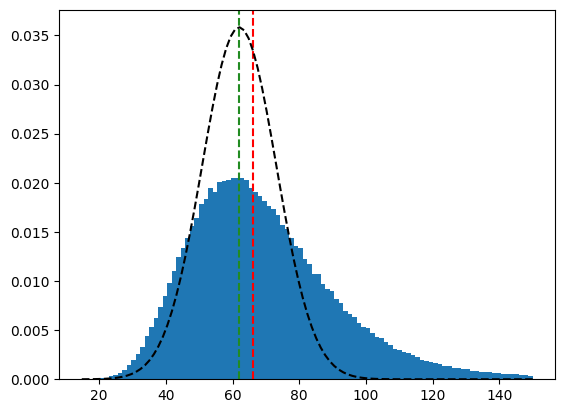

In [144]:
tbins = plt.hist(chi2_table[chi2_table['chi2_mass_mh'] < 150]['chi2_mass_mh'], bins=100, density=True);
plt.axvline(x=62, c="forestgreen", linestyle="--")
plt.axvline(x=np.median(chi2_table["chi2_mass_mh"]), c="r", linestyle="--")

gaussian_points = gaussian(tbins[1], 62, np.sqrt(62)*np.sqrt(2))
gausian_points = gaussian_points / np.sum(gaussian_points)
plt.plot(tbins[1], gaussian_points, c="k", linestyle="--")

In [128]:
np.median(chi2_table["chi2_mass_mh"])

np.float64(66.17675)

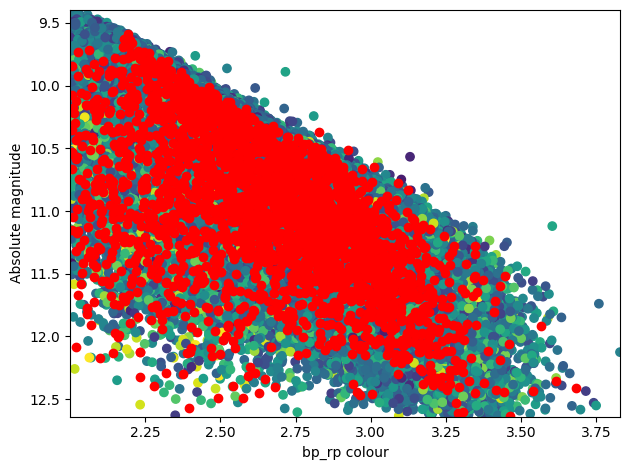

In [75]:
low_mask = chi2_table['chi2_mass_mh'] > 150

bp_rp = t_loaded["bp_rp"]
parallax = t_loaded["parallax"]
gmag = t_loaded["phot_g_mean_mag"]
absolute_magnitudes = gmag + 5 * np.log10(parallax) - 10

plt.scatter(bp_rp[np.invert(low_mask)], absolute_magnitudes[np.invert(low_mask)], c=chi2_table[np.invert(low_mask)]["chi2_mass_mh"]);
plt.scatter(bp_rp[low_mask], absolute_magnitudes[low_mask], color="red");
plt.ylabel("Absolute magnitude");
plt.xlabel("bp_rp colour");
plt.ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes));
plt.xlim([np.min(bp_rp), np.max(bp_rp)]);
plt.tight_layout()

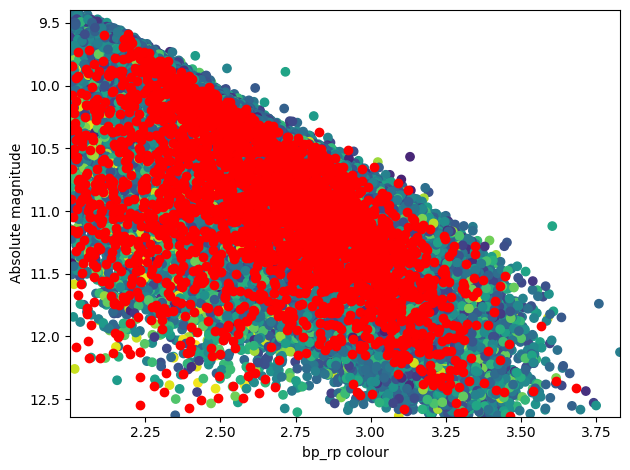

In [77]:
low_mask = chi2_table['chi2_mass_mh_binary'] > 150

bp_rp = t_loaded["bp_rp"]
parallax = t_loaded["parallax"]
gmag = t_loaded["phot_g_mean_mag"]
absolute_magnitudes = gmag + 5 * np.log10(parallax) - 10

plt.scatter(bp_rp[np.invert(low_mask)], absolute_magnitudes[np.invert(low_mask)], c=chi2_table[np.invert(low_mask)]["chi2_mass_mh_binary"]);
plt.scatter(bp_rp[low_mask], absolute_magnitudes[low_mask], color="red");
plt.ylabel("Absolute magnitude");
plt.xlabel("bp_rp colour");
plt.ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes));
plt.xlim([np.min(bp_rp), np.max(bp_rp)]);
plt.tight_layout()

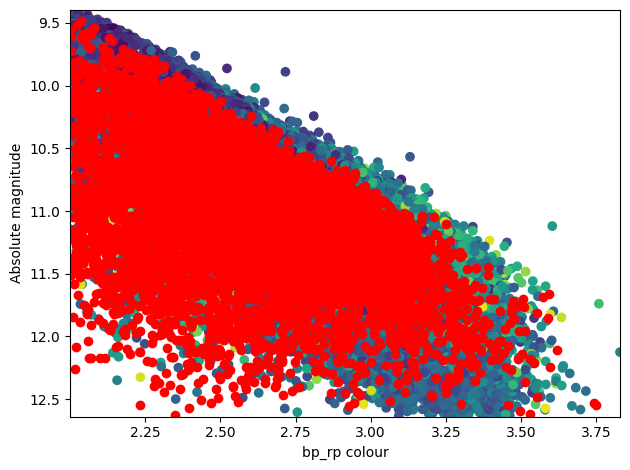

In [97]:
low_mask = chi2_table["parallax_error"]/t_loaded["parallax"] > 0.03

bp_rp = t_loaded["bp_rp"]
parallax = t_loaded["parallax"]
gmag = t_loaded["phot_g_mean_mag"]
absolute_magnitudes = gmag + 5 * np.log10(parallax) - 10

plt.scatter(bp_rp[np.invert(low_mask)], absolute_magnitudes[np.invert(low_mask)], c=chi2_table[np.invert(low_mask)]["parallax_error"]/t_loaded[np.invert(low_mask)]["parallax"]);
plt.scatter(bp_rp[low_mask], absolute_magnitudes[low_mask], color="red");
plt.ylabel("Absolute magnitude");
plt.xlabel("bp_rp colour");
plt.ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes));
plt.xlim([np.min(bp_rp), np.max(bp_rp)]);
plt.tight_layout()

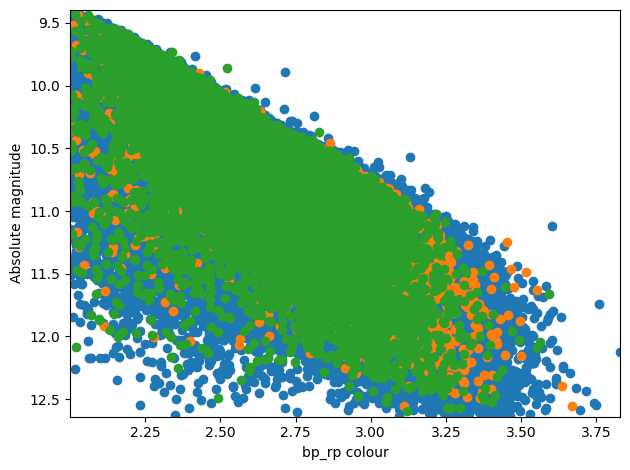

In [83]:
bp_rp = t_loaded["bp_rp"]
parallax = t_loaded["parallax"]
gmag = t_loaded["phot_g_mean_mag"]
absolute_magnitudes = gmag + 5 * np.log10(parallax) - 10

for lbl in [2,3,4]:
    type_mask = chi2_table["fit_status_single"] == lbl
    plt.scatter(bp_rp[type_mask], absolute_magnitudes[type_mask]);
plt.ylabel("Absolute magnitude");
plt.xlabel("bp_rp colour");
plt.ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes));
plt.xlim([np.min(bp_rp), np.max(bp_rp)]);
plt.tight_layout()

doesn't look like it tells us much :(

### isochrone cuts

the idea here will be to throw an isochrone with the oldest mass and lowest metallicity, to trim out the 'impossible' objects

In [13]:
isochrone_data = np.genfromtxt('../../DR3_planet_candidate_identification/data/isochrones.dat',
                     skip_header=13,
                     skip_footer=1,
                     names=True,
                     dtype=None)

In [14]:
print(np.unique(isochrone_data["logAge"]))
print(np.unique(isochrone_data["MH"]))

[7.      7.1     7.2     7.3     7.4     7.5     7.6     7.7     7.8
 7.9     8.      8.1     8.2     8.3     8.4     8.5     8.6     8.7
 8.8     8.9     9.      9.1     9.2     9.3     9.4     9.5     9.60001
 9.70001 9.80001 9.90001]
[-0.6 -0.5 -0.4 -0.3 -0.2 -0.1 -0.   0.1  0.2  0.3]


In [15]:
def outside_isochrones(iso_x, iso_y, target_point):
    return np.interp(x=target_point[0], xp=iso_x, fp=iso_y) > target_point[1]

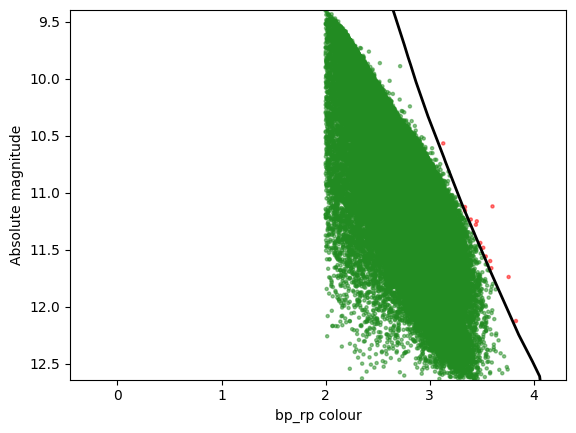

In [16]:
fig, ax = plt.subplots(1, 1)
bp_rps = t_loaded["bp_rp"]
parallax = t_loaded["parallax"]
gmag = t_loaded["phot_g_mean_mag"]
absolute_mags = gmag + 5 * np.log10(parallax) - 10

isochrone_mags = isochrone_data["Gmag"]
isochrone_cols = isochrone_data["G_BPmag"] - isochrone_data["G_RPmag"]
upper_mask = (isochrone_mags < 13) & (isochrone_mags > -2) & (isochrone_cols < 5) & (isochrone_data["MH"] == 0.3) & (isochrone_data["logAge"] == 7.8)
edge_isochrone_cols, edge_isochrone_mags = isochrone_cols[upper_mask], isochrone_mags[upper_mask]
plt.plot(edge_isochrone_cols, edge_isochrone_mags, c="k", linewidth=2);

coords = list(zip(edge_isochrone_mags, edge_isochrone_cols))
coords.sort()
x_sorted, y_sorted = zip(*coords)

color_list = np.array(["red", "forestgreen"])
indxs = np.array(outside_isochrones(x_sorted, y_sorted, (absolute_mags, bp_rps)), dtype=int)
cols = color_list[indxs]

ax.scatter(bp_rps, absolute_mags,
                c=cols, s=5, alpha=0.5)
ax.set_ylim([np.max(absolute_mags), np.min(absolute_mags)])
ax.set_ylabel("Absolute magnitude");
ax.set_xlabel("bp_rp colour");

probably don't need this one

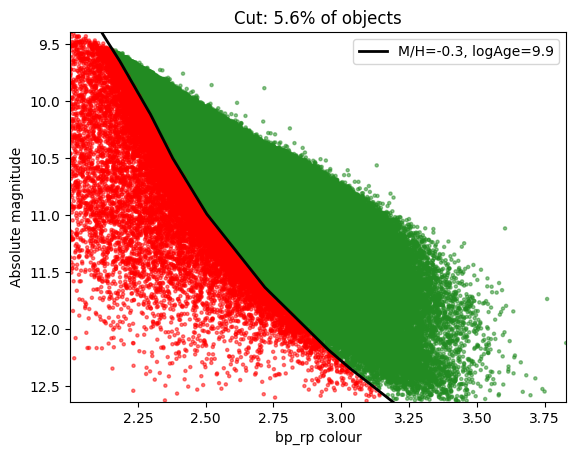

In [17]:
fig, ax = plt.subplots(1, 1)

isochrone_mags = isochrone_data["Gmag"]
isochrone_cols = isochrone_data["G_BPmag"] - isochrone_data["G_RPmag"]
edge_mask = (isochrone_cols < 4.5) & (isochrone_mags > -3) & (isochrone_mags < 13) & (isochrone_data["MH"] == -0.3) & (isochrone_data["logAge"] == 9.90001)
edge_isochrone_cols, edge_isochrone_mags = isochrone_cols[edge_mask], isochrone_mags[edge_mask]
plt.plot(edge_isochrone_cols, edge_isochrone_mags, c="k", linewidth=2, label="M/H=-0.3, logAge=9.9");

coords = list(zip(edge_isochrone_mags, edge_isochrone_cols))
coords.sort()
x_sorted, y_sorted = zip(*coords)

color_list = np.array(["red", "forestgreen"])
indxs = np.array(np.invert(outside_isochrones(x_sorted, y_sorted, (absolute_mags, bp_rps))), dtype=int)
cols = color_list[indxs]

ax.scatter(bp_rps, absolute_mags,
                c=cols, s=5, alpha=0.5)
ax.set_ylim([np.max(absolute_mags), np.min(absolute_mags)])
ax.set_xlim([np.min(bp_rps), np.max(bp_rps)])
ax.set_ylabel("Absolute magnitude");
ax.set_xlabel("bp_rp colour");
ax.set_title("Cut: 5.6% of objects");
ax.legend();

In [18]:
def get_sorted_isochrone_points(isochrone_mags, isochrone_cols, edge_mask, get_edgevals=False):
    edge_isochrone_cols, edge_isochrone_mags = isochrone_cols[edge_mask], isochrone_mags[edge_mask]
    if get_edgevals:
        return edge_isochrone_cols, edge_isochrone_mags
    coords = list(zip(edge_isochrone_mags, edge_isochrone_cols))
    coords.sort()
    x_sorted, y_sorted = zip(*coords)
    return x_sorted, y_sorted

In [19]:
isochrone_mask = (isochrone_cols < 4.5) & (isochrone_mags > -3) & (isochrone_mags < 13) & (isochrone_data["MH"] == -0.3) & (isochrone_data["logAge"] == 9.90001)
x_sorted, y_sorted = get_sorted_isochrone_points(isochrone_mags, isochrone_cols, isochrone_mask)
table_isochrone_mask = np.invert(outside_isochrones(x_sorted, y_sorted, (absolute_mags, bp_rps)))
reduced_t_loaded = t_loaded[table_isochrone_mask]

In [20]:
print(len(t_loaded), "->", len(reduced_t_loaded), "{:.1f}%".format(len(reduced_t_loaded)/len(t_loaded)*100))

275438 -> 260095 94.4%


In [14]:
reduced_t_loaded.write('../data/200pc_mdwarfs_reduced.fits', format='fits', overwrite=True)

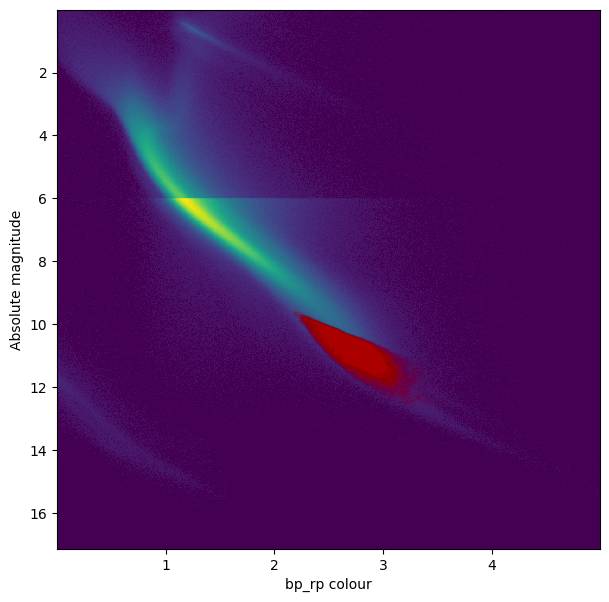

In [25]:
new_table = Table()
labels = ["source_id", "parallax", "ra", "dec", "phot_g_mean_mag", "mass_single", "predicted_class", "bp_rp", "mh_single"]
for label in labels:
    new_table.add_column(np.array(msms["table"]["columns"][label]["data"]), name=label)
bp_rp = new_table["bp_rp"]
parallax = new_table["parallax"]
gmag = new_table["phot_g_mean_mag"]
absolute_magnitudes = gmag + 5 * np.log10(parallax) - 10

fig, ax = plt.subplots(figsize=(7,7))
ax.hist2d(bp_rp, absolute_magnitudes, bins=1000, norm=matplotlib.colors.PowerNorm(0.4));
ax.set_ylabel("Absolute magnitude");
ax.set_xlabel("bp_rp colour");
ax.set_ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes));
ax.set_xlim([np.min(bp_rp), np.max(bp_rp)]);

bp_rp = reduced_t_loaded["bp_rp"]
parallax = reduced_t_loaded["parallax"]
gmag = reduced_t_loaded["phot_g_mean_mag"]
absolute_magnitudes = gmag + 5 * np.log10(parallax) - 10
ax.scatter(bp_rp[::10], absolute_magnitudes[::10], color="red", alpha=1e-2, s=5);

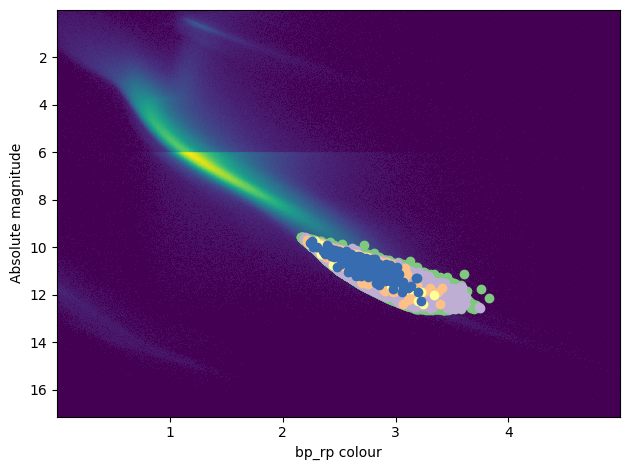

In [162]:
new_table = Table()
labels = ["source_id", "parallax", "ra", "dec", "phot_g_mean_mag", "mass_single", "predicted_class", "bp_rp", "mh_single"]
for label in labels:
    new_table.add_column(np.array(msms["table"]["columns"][label]["data"]), name=label)
bp_rp = new_table["bp_rp"]
parallax = new_table["parallax"]
gmag = new_table["phot_g_mean_mag"]
absolute_magnitudes = gmag + 5 * np.log10(parallax) - 10

plt.hist2d(bp_rp, absolute_magnitudes, bins=1000, norm=matplotlib.colors.PowerNorm(0.4));
plt.ylabel("Absolute magnitude");
plt.xlabel("bp_rp colour");
plt.ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes));
plt.xlim([np.min(bp_rp), np.max(bp_rp)]);

for i in range(5):
    soltype_mask = reduced_t_loaded["solution_type"] == soltypes[i]
    
    bp_rp = reduced_t_loaded[soltype_mask]["bp_rp"]
    parallax = reduced_t_loaded[soltype_mask]["parallax"]
    gmag = reduced_t_loaded[soltype_mask]["phot_g_mean_mag"]
    absolute_magnitudes = gmag + 5 * np.log10(parallax) - 10
    plt.scatter(bp_rp, absolute_magnitudes, color=solution_colormap[i]);
    
plt.tight_layout()

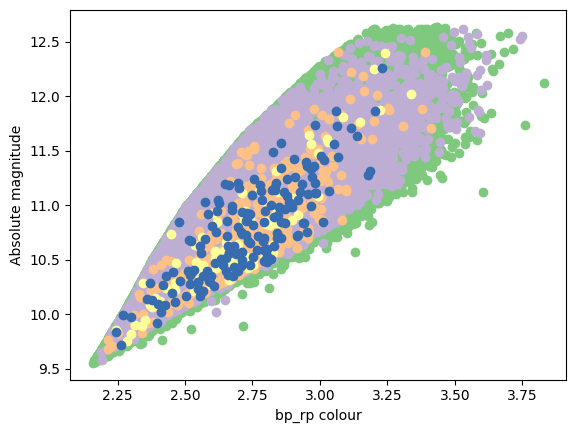

In [163]:
for i in range(5):
    soltype_mask = reduced_t_loaded["solution_type"] == soltypes[i]
    
    bp_rp = reduced_t_loaded[soltype_mask]["bp_rp"]
    parallax = reduced_t_loaded[soltype_mask]["parallax"]
    gmag = reduced_t_loaded[soltype_mask]["phot_g_mean_mag"]
    absolute_magnitudes = gmag + 5 * np.log10(parallax) - 10
    plt.scatter(bp_rp, absolute_magnitudes, color=solution_colormap[i]);

plt.ylabel("Absolute magnitude");
plt.xlabel("bp_rp colour");

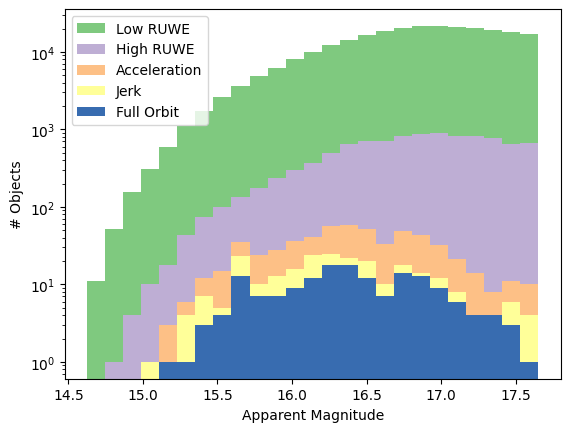

In [164]:
tbins = plt.hist(reduced_t_loaded["phot_g_mean_mag"], color=solution_colormap[0], bins=25, label="Low RUWE");
plt.hist(reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [5, 7, 9, 12])]["phot_g_mean_mag"], bins=tbins[1], color=solution_colormap[1], label="High RUWE");
plt.hist(reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [7, 9, 12])]["phot_g_mean_mag"], bins=tbins[1], color=solution_colormap[2], label="Acceleration");
plt.hist(reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [9, 12])]["phot_g_mean_mag"], bins=tbins[1], color=solution_colormap[3], label="Jerk");
plt.hist(reduced_t_loaded[reduced_t_loaded["solution_type"] == 12]["phot_g_mean_mag"], bins=tbins[1], color=solution_colormap[4], label="Full Orbit");
plt.yscale("log");
plt.xlabel("Apparent Magnitude");
plt.ylabel("# Objects");
plt.legend();

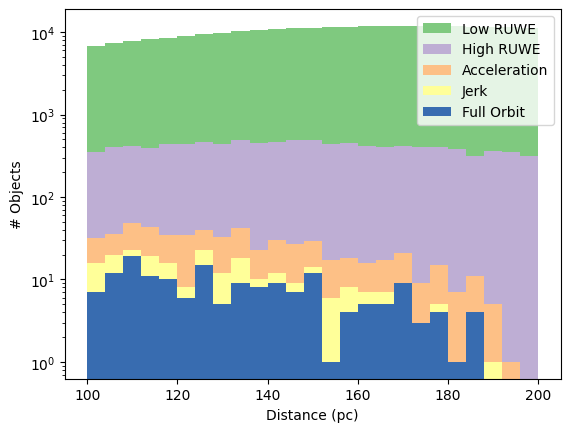

In [165]:
tbins = plt.hist(1000/reduced_t_loaded["parallax"], color=solution_colormap[0], bins=25, label="Low RUWE");
plt.hist(1000/reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [5, 7, 9, 12])]["parallax"], bins=tbins[1], color=solution_colormap[1], label="High RUWE");
plt.hist(1000/reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [7, 9, 12])]["parallax"], bins=tbins[1], color=solution_colormap[2], label="Acceleration");
plt.hist(1000/reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [9, 12])]["parallax"], bins=tbins[1], color=solution_colormap[3], label="Jerk");
plt.hist(1000/reduced_t_loaded[reduced_t_loaded["solution_type"] == 12]["parallax"], bins=tbins[1], color=solution_colormap[4], label="Full Orbit");
plt.yscale("log");
plt.xlabel("Distance (pc)");
plt.ylabel("# Objects");
plt.legend();

In [27]:
# FETCH ENTIRE DATASET
new_table = Table()
labels = ["parallax", "phot_g_mean_mag", "bp_rp"]
for label in labels:
    new_table.add_column(np.array(msms["table"]["columns"][label]["data"]), name=label)
bp_rp = new_table["bp_rp"]
parallax = new_table["parallax"]
gmag = new_table["phot_g_mean_mag"]
absolute_magnitudes = gmag + 5 * np.log10(parallax) - 10

bp_rps = t_loaded["bp_rp"]
parallaxes = t_loaded["parallax"]
gmages = t_loaded["phot_g_mean_mag"]
absolute_mags = gmages + 5 * np.log10(parallaxes) - 10

# SET UP PASTEL COLOURS
soltypes = [0,5,7,9,12]
solution_colormap = plt.get_cmap('Accent')(np.linspace(0, 1, 8))[:5]
CMAP = matplotlib.colors.ListedColormap(solution_colormap)

/tmp/ipykernel_3781087/283800351.py:49: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("../plots/dataset.jpg")


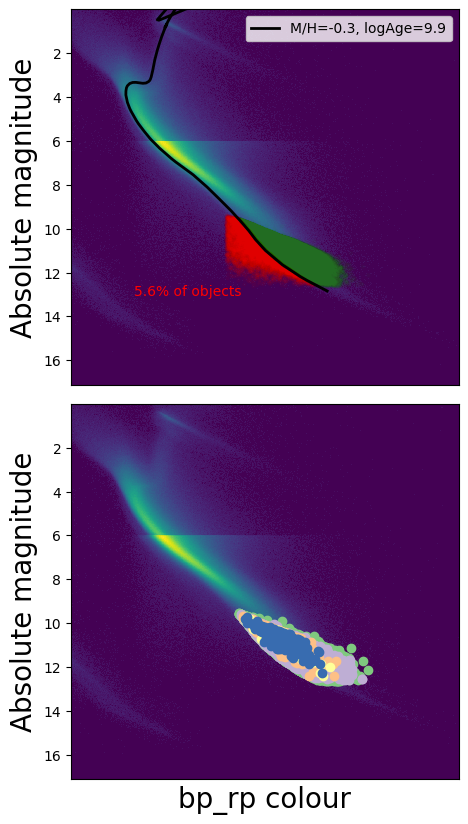

In [71]:
fig, axs = plt.subplots(2,1, figsize=(5,10), sharex=True)
labelsize = 20
# CMD WITH ISOCHRONE CUT
axs[0].hist2d(bp_rp, absolute_magnitudes, bins=1000, norm=matplotlib.colors.PowerNorm(0.4));
axs[0].set_ylabel("Absolute magnitude", fontsize=labelsize);
#axs[0].set_xlabel("bp_rp colour", fontsize=labelsize);
axs[0].set_xticks([])
axs[0].set_ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes));
axs[0].set_xlim([np.min(bp_rp), np.max(bp_rp)]);

isochrone_mags = isochrone_data["Gmag"]
isochrone_cols = isochrone_data["G_BPmag"] - isochrone_data["G_RPmag"]
edge_mask = (isochrone_cols < 4.5) & (isochrone_mags > -3) & (isochrone_mags < 13) & (isochrone_data["MH"] == -0.3) & (isochrone_data["logAge"] == 9.90001)
edge_isochrone_cols, edge_isochrone_mags = isochrone_cols[edge_mask], isochrone_mags[edge_mask]
axs[0].plot(edge_isochrone_cols, edge_isochrone_mags, c="k", linewidth=2, label="M/H=-0.3, logAge=9.9");

coords = list(zip(edge_isochrone_mags, edge_isochrone_cols))
coords.sort()
x_sorted, y_sorted = zip(*coords)

color_list = np.array(["red", "forestgreen"])
indxs = np.array(np.invert(outside_isochrones(x_sorted, y_sorted, (absolute_mags, bp_rps))), dtype=int)
cols = color_list[indxs]

axs[0].scatter(bp_rps, absolute_mags,
                c=cols, s=5, alpha=0.03)
axs[0].text(0.3,0.25, "5.6% of objects", color="red", fontsize=10,
              transform=axs[0].transAxes, ha='center', va='center')
axs[0].legend()

# CMD WITH SOLUTION TYPES
axs[1].hist2d(bp_rp, absolute_magnitudes, bins=1000, norm=matplotlib.colors.PowerNorm(0.4));
axs[1].set_ylabel("Absolute magnitude", fontsize=labelsize);
axs[1].set_xlabel("bp_rp colour", fontsize=labelsize);
axs[1].set_ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes));
axs[1].set_xlim([np.min(bp_rp), np.max(bp_rp)]);

for i in range(5):
    soltype_mask = reduced_t_loaded["solution_type"] == soltypes[i]
    
    cat_bp_rp = reduced_t_loaded[soltype_mask]["bp_rp"]
    cat_parallax = reduced_t_loaded[soltype_mask]["parallax"]
    cat_gmag = reduced_t_loaded[soltype_mask]["phot_g_mean_mag"]
    cat_absolute_magnitudes = cat_gmag + 5 * np.log10(cat_parallax) - 10
    axs[1].scatter(cat_bp_rp, cat_absolute_magnitudes, color=solution_colormap[i]);

plt.subplots_adjust(hspace=0.05)

plt.savefig("../plots/dataset.jpg")

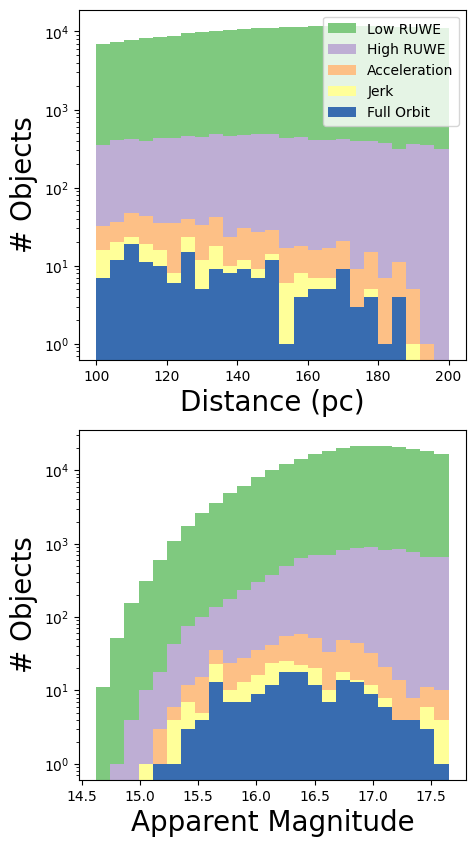

In [74]:
fig, axs = plt.subplots(2,1, figsize=(5,10))
labelsize = 20
# DISTANCE HISTOGRAM
tbins = axs[0].hist(1000/reduced_t_loaded["parallax"], color=solution_colormap[0], bins=25, label="Low RUWE");
axs[0].hist(1000/reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [5, 7, 9, 12])]["parallax"], bins=tbins[1], color=solution_colormap[1], label="High RUWE");
axs[0].hist(1000/reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [7, 9, 12])]["parallax"], bins=tbins[1], color=solution_colormap[2], label="Acceleration");
axs[0].hist(1000/reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [9, 12])]["parallax"], bins=tbins[1], color=solution_colormap[3], label="Jerk");
axs[0].hist(1000/reduced_t_loaded[reduced_t_loaded["solution_type"] == 12]["parallax"], bins=tbins[1], color=solution_colormap[4], label="Full Orbit");
axs[0].set_yscale("log");
axs[0].set_xlabel("Distance (pc)", fontsize=labelsize);
axs[0].set_ylabel("# Objects", fontsize=labelsize);
axs[0].legend();

# APPARENT MAGNITUDE HISTOGRAM
tbins = axs[1].hist(reduced_t_loaded["phot_g_mean_mag"], color=solution_colormap[0], bins=25, label="Low RUWE");
axs[1].hist(reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [5, 7, 9, 12])]["phot_g_mean_mag"], bins=tbins[1], color=solution_colormap[1], label="High RUWE");
axs[1].hist(reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [7, 9, 12])]["phot_g_mean_mag"], bins=tbins[1], color=solution_colormap[2], label="Acceleration");
axs[1].hist(reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [9, 12])]["phot_g_mean_mag"], bins=tbins[1], color=solution_colormap[3], label="Jerk");
axs[1].hist(reduced_t_loaded[reduced_t_loaded["solution_type"] == 12]["phot_g_mean_mag"], bins=tbins[1], color=solution_colormap[4], label="Full Orbit");
axs[1].set_yscale("log");
axs[1].set_xlabel("Apparent Magnitude", fontsize=labelsize);
axs[1].set_ylabel("# Objects", fontsize=labelsize);

plt.savefig("../plots/histograms.jpg")

In [61]:
rates = [len(reduced_t_loaded[reduced_t_loaded["solution_type"] == soltype]) / len(reduced_t_loaded) * 100
         for soltype in [0, 5, 7, 9, 12]]

counts = [int(r/100 * len(reduced_t_loaded)) for r in rates]

row_labels = ["Rate (%)", "Counts"]
col_labels = ["low RUWE", "high RUWE", "Acceleration", "Jerk", "Full Orbit"]

# numeric table (keeps original types)
df = pd.DataFrame([rates, counts], index=row_labels, columns=col_labels)

# formatted table (all strings, safe)
df_formatted = pd.DataFrame({
    col: [
        f"{df.loc['Rate (%)', col]:.2f}",   # format row 1
        f"{int(df.loc['Counts', col])}"     # format row 2
    ]
    for col in col_labels
}, index=row_labels)

latex_table = df_formatted.to_latex(escape=False, index=True)

with open("../plots/mdwarf_table.tex", "w") as f:
    f.write(latex_table)
    
df_formatted

,low RUWE,high RUWE,Acceleration,Jerk,Full Orbit
Rate (%),96.02,3.76,0.13,0.03,0.06
Counts,249731,9774,338,85,166


In [75]:
len(reduced_t_loaded)

260095

/tmp/ipykernel_3781087/1676786048.py:91: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


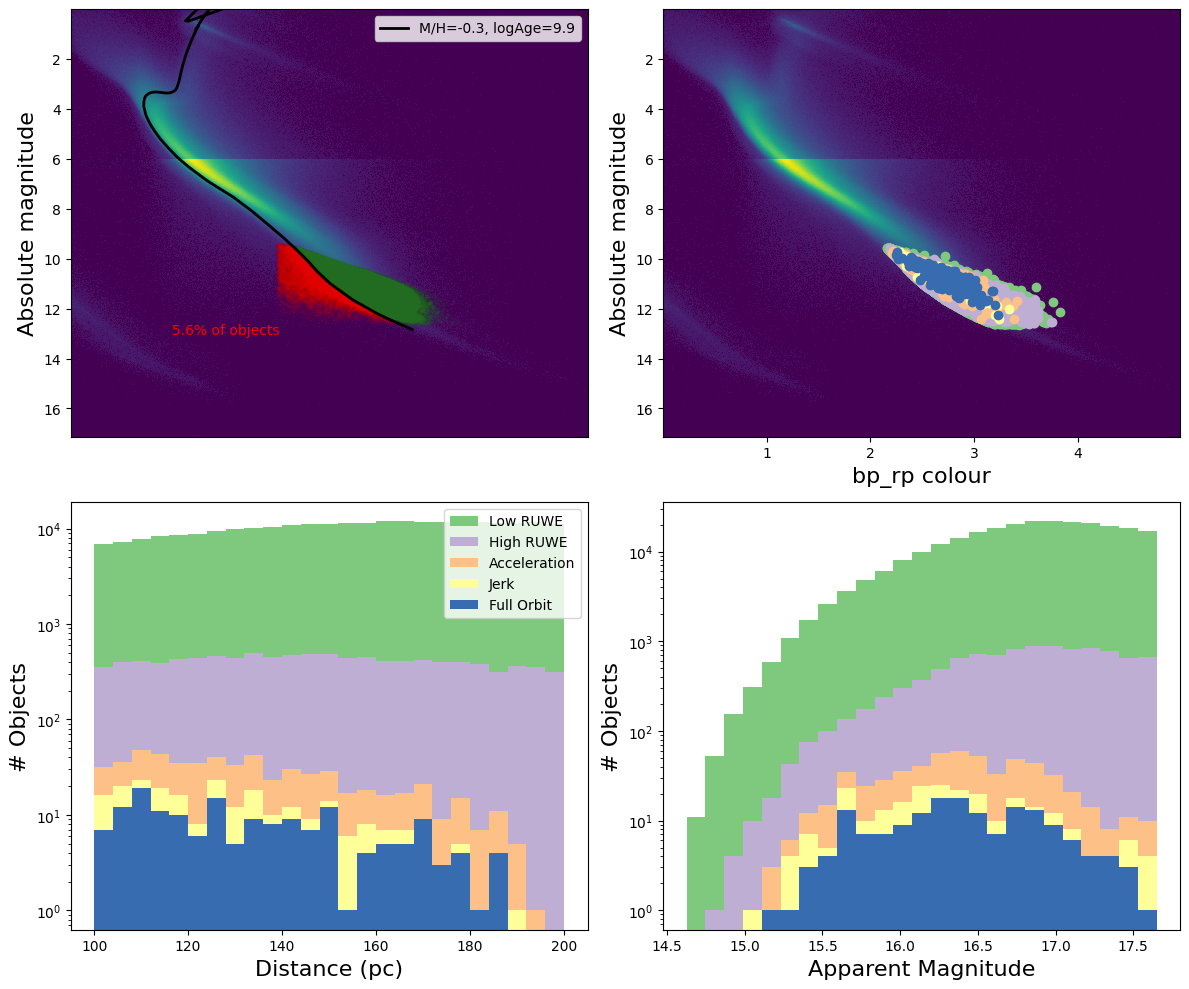

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
labelsize = 16

# ------------------------------------------
# Top-left: CMD WITH ISOCHRONE CUT
# ------------------------------------------
ax = axs[0, 0]
ax.hist2d(bp_rp, absolute_magnitudes, bins=1000, norm=matplotlib.colors.PowerNorm(0.4))
ax.set_ylabel("Absolute magnitude", fontsize=labelsize)
ax.set_xlabel("bp_rp colour")
ax.set_ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes))
ax.set_xlim([np.min(bp_rp), np.max(bp_rp)])

isochrone_mags = isochrone_data["Gmag"]
isochrone_cols = isochrone_data["G_BPmag"] - isochrone_data["G_RPmag"]
edge_mask = (isochrone_cols < 4.5) & (isochrone_mags > -3) & (isochrone_mags < 13) & \
            (isochrone_data["MH"] == -0.3) & (isochrone_data["logAge"] == 9.90001)
edge_isochrone_cols, edge_isochrone_mags = isochrone_cols[edge_mask], isochrone_mags[edge_mask]
ax.plot(edge_isochrone_cols, edge_isochrone_mags, c="k", linewidth=2, label="M/H=-0.3, logAge=9.9")

coords = list(zip(edge_isochrone_mags, edge_isochrone_cols))
coords.sort()
x_sorted, y_sorted = zip(*coords)

color_list = np.array(["red", "forestgreen"])
indxs = np.array(np.invert(outside_isochrones(x_sorted, y_sorted, (absolute_mags, bp_rps))), dtype=int)
cols = color_list[indxs]

ax.scatter(bp_rps, absolute_mags, c=cols, s=5, alpha=0.03)
ax.text(0.3, 0.25, "5.6% of objects", color="red", fontsize=10,
        transform=ax.transAxes, ha='center', va='center')
ax.legend()

# ------------------------------------------
# Top-right: CMD WITH SOLUTION TYPES
# ------------------------------------------
ax = axs[0, 1]
ax.hist2d(bp_rp, absolute_magnitudes, bins=1000, norm=matplotlib.colors.PowerNorm(0.4))
ax.set_ylabel("Absolute magnitude", fontsize=labelsize)
ax.set_xlabel("bp_rp colour", fontsize=labelsize)
ax.set_ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes))
ax.set_xlim([np.min(bp_rp), np.max(bp_rp)])

for i in range(5):
    soltype_mask = reduced_t_loaded["solution_type"] == soltypes[i]
    cat_bp_rp = reduced_t_loaded[soltype_mask]["bp_rp"]
    cat_parallax = reduced_t_loaded[soltype_mask]["parallax"]
    cat_gmag = reduced_t_loaded[soltype_mask]["phot_g_mean_mag"]
    cat_absolute_magnitudes = cat_gmag + 5 * np.log10(cat_parallax) - 10
    ax.scatter(cat_bp_rp, cat_absolute_magnitudes, color=solution_colormap[i])

# ------------------------------------------
# Bottom-left: DISTANCE HISTOGRAM
# ------------------------------------------
ax = axs[1, 0]
tbins = ax.hist(1000/reduced_t_loaded["parallax"], color=solution_colormap[0], bins=25, label="Low RUWE")
ax.hist(1000/reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [5, 7, 9, 12])]["parallax"],
        bins=tbins[1], color=solution_colormap[1], label="High RUWE")
ax.hist(1000/reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [7, 9, 12])]["parallax"],
        bins=tbins[1], color=solution_colormap[2], label="Acceleration")
ax.hist(1000/reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [9, 12])]["parallax"],
        bins=tbins[1], color=solution_colormap[3], label="Jerk")
ax.hist(1000/reduced_t_loaded[reduced_t_loaded["solution_type"] == 12]["parallax"],
        bins=tbins[1], color=solution_colormap[4], label="Full Orbit")
ax.set_yscale("log")
ax.set_xlabel("Distance (pc)", fontsize=labelsize)
ax.set_ylabel("# Objects", fontsize=labelsize)
ax.legend(fontsize=10)

# ------------------------------------------
# Bottom-right: APPARENT MAGNITUDE HISTOGRAM
# ------------------------------------------
ax = axs[1, 1]
tbins = ax.hist(reduced_t_loaded["phot_g_mean_mag"], color=solution_colormap[0], bins=25, label="Low RUWE")
ax.hist(reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [5, 7, 9, 12])]["phot_g_mean_mag"],
        bins=tbins[1], color=solution_colormap[1], label="High RUWE")
ax.hist(reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [7, 9, 12])]["phot_g_mean_mag"],
        bins=tbins[1], color=solution_colormap[2], label="Acceleration")
ax.hist(reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [9, 12])]["phot_g_mean_mag"],
        bins=tbins[1], color=solution_colormap[3], label="Jerk")
ax.hist(reduced_t_loaded[reduced_t_loaded["solution_type"] == 12]["phot_g_mean_mag"],
        bins=tbins[1], color=solution_colormap[4], label="Full Orbit")
ax.set_yscale("log")
ax.set_xlabel("Apparent Magnitude", fontsize=labelsize)
ax.set_ylabel("# Objects", fontsize=labelsize)

plt.tight_layout()
plt.savefig("../plots/combined_2x2_figure.jpg")


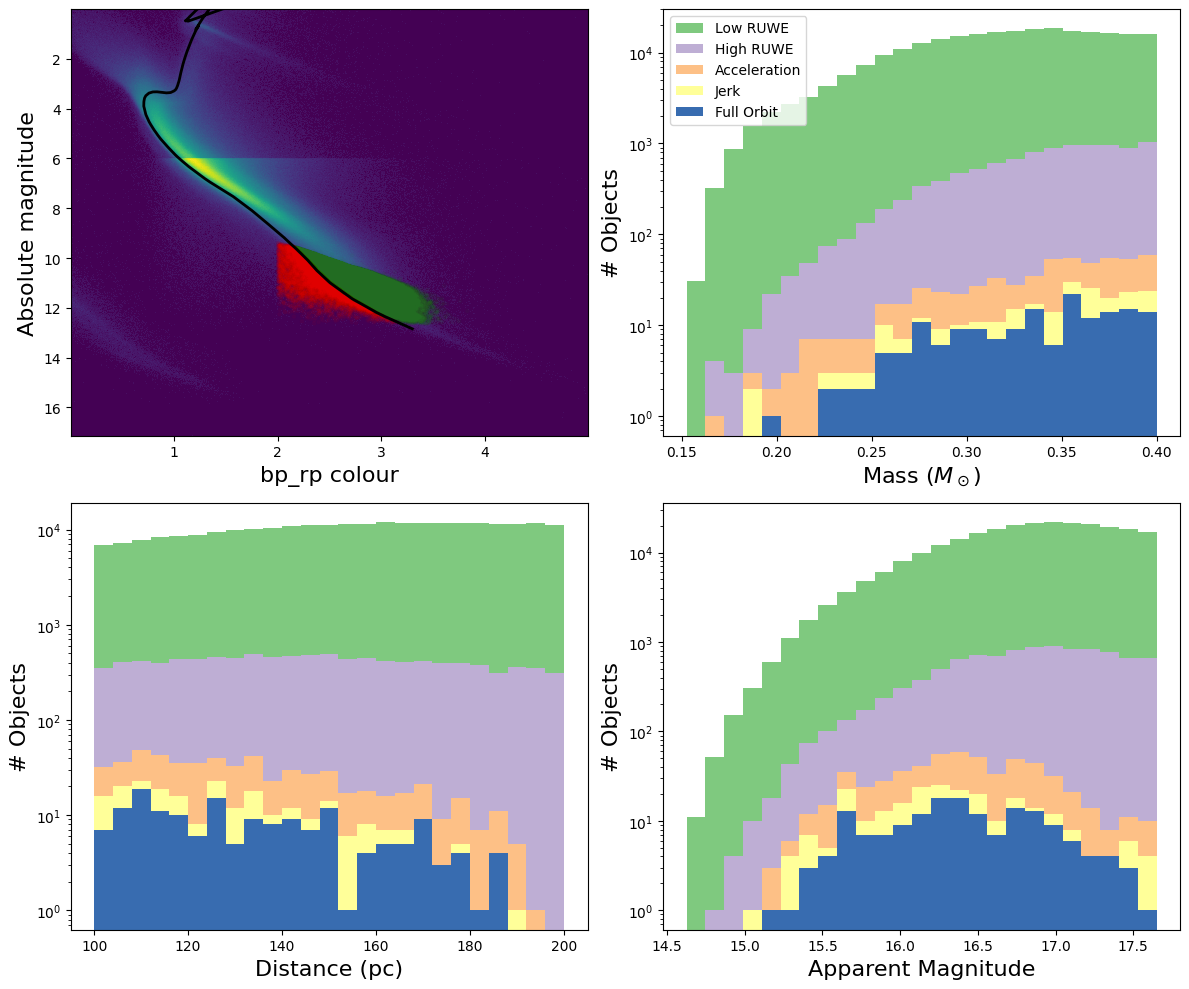

In [28]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
labelsize = 16

# ------------------------------------------
# Top-left: CMD WITH ISOCHRONE CUT
# ------------------------------------------
ax = axs[0, 0]
ax.hist2d(bp_rp, absolute_magnitudes, bins=1000, norm=matplotlib.colors.PowerNorm(0.4))
ax.set_ylabel("Absolute magnitude", fontsize=labelsize)
ax.set_xlabel("bp_rp colour", fontsize=labelsize)
ax.set_ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes))
ax.set_xlim([np.min(bp_rp), np.max(bp_rp)])

isochrone_mags = isochrone_data["Gmag"]
isochrone_cols = isochrone_data["G_BPmag"] - isochrone_data["G_RPmag"]
edge_mask = (isochrone_cols < 4.5) & (isochrone_mags > -3) & (isochrone_mags < 13) & \
            (isochrone_data["MH"] == -0.3) & (isochrone_data["logAge"] == 9.90001)
edge_isochrone_cols, edge_isochrone_mags = isochrone_cols[edge_mask], isochrone_mags[edge_mask]
ax.plot(edge_isochrone_cols, edge_isochrone_mags, c="k", linewidth=2)#, label="M/H=-0.3, logAge=9.9")

coords = list(zip(edge_isochrone_mags, edge_isochrone_cols))
coords.sort()
x_sorted, y_sorted = zip(*coords)

color_list = np.array(["red", "forestgreen"])
indxs = np.array(np.invert(outside_isochrones(x_sorted, y_sorted, (absolute_mags, bp_rps))), dtype=int)
cols = color_list[indxs]

ax.scatter(bp_rps, absolute_mags, c=cols, s=5, alpha=0.03)
# ax.text(0.3, 0.25, "5.6% of objects", color="red", fontsize=10,
#         transform=ax.transAxes, ha='center', va='center')
#ax.legend()

# ------------------------------------------
# Top-right: MASS HISTOGRAM
# ------------------------------------------
ax = axs[0, 1]
tbins = ax.hist(reduced_t_loaded["mass_single"], color=solution_colormap[0], bins=25, label="Low RUWE")
ax.hist(reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [5, 7, 9, 12])]["mass_single"],
        bins=tbins[1], color=solution_colormap[1], label="High RUWE")
ax.hist(reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [7, 9, 12])]["mass_single"],
        bins=tbins[1], color=solution_colormap[2], label="Acceleration")
ax.hist(reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [9, 12])]["mass_single"],
        bins=tbins[1], color=solution_colormap[3], label="Jerk")
ax.hist(reduced_t_loaded[reduced_t_loaded["solution_type"] == 12]["mass_single"],
        bins=tbins[1], color=solution_colormap[4], label="Full Orbit")
ax.set_yscale("log")
ax.set_xlabel(r"Mass ($M_\odot$)", fontsize=labelsize)
ax.set_ylabel("# Objects", fontsize=labelsize)
ax.legend(fontsize=10)

# ------------------------------------------
# Bottom-left: DISTANCE HISTOGRAM
# ------------------------------------------
ax = axs[1, 0]
tbins = ax.hist(1000/reduced_t_loaded["parallax"], color=solution_colormap[0], bins=25, label="Low RUWE")
ax.hist(1000/reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [5, 7, 9, 12])]["parallax"],
        bins=tbins[1], color=solution_colormap[1], label="High RUWE")
ax.hist(1000/reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [7, 9, 12])]["parallax"],
        bins=tbins[1], color=solution_colormap[2], label="Acceleration")
ax.hist(1000/reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [9, 12])]["parallax"],
        bins=tbins[1], color=solution_colormap[3], label="Jerk")
ax.hist(1000/reduced_t_loaded[reduced_t_loaded["solution_type"] == 12]["parallax"],
        bins=tbins[1], color=solution_colormap[4], label="Full Orbit")
ax.set_yscale("log")
ax.set_xlabel("Distance (pc)", fontsize=labelsize)
ax.set_ylabel("# Objects", fontsize=labelsize)

# ------------------------------------------
# Bottom-right: APPARENT MAGNITUDE HISTOGRAM
# ------------------------------------------
ax = axs[1, 1]
tbins = ax.hist(reduced_t_loaded["phot_g_mean_mag"], color=solution_colormap[0], bins=25, label="Low RUWE")
ax.hist(reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [5, 7, 9, 12])]["phot_g_mean_mag"],
        bins=tbins[1], color=solution_colormap[1], label="High RUWE")
ax.hist(reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [7, 9, 12])]["phot_g_mean_mag"],
        bins=tbins[1], color=solution_colormap[2], label="Acceleration")
ax.hist(reduced_t_loaded[np.isin(reduced_t_loaded["solution_type"], [9, 12])]["phot_g_mean_mag"],
        bins=tbins[1], color=solution_colormap[3], label="Jerk")
ax.hist(reduced_t_loaded[reduced_t_loaded["solution_type"] == 12]["phot_g_mean_mag"],
        bins=tbins[1], color=solution_colormap[4], label="Full Orbit")
ax.set_yscale("log")
ax.set_xlabel("Apparent Magnitude", fontsize=labelsize)
ax.set_ylabel("# Objects", fontsize=labelsize)

plt.tight_layout()
plt.savefig("../plots/combined_2x2_figure_mass.jpg")